In [200]:
###################################################################
#
# Author: Matthew W. Boyce, PhD, boyce.matthew@epa.gov
#
# Version: 1.0 6-08-2020
#
# Description:  This notebook covers the reading, cleaning, and analysis
#               of preliminary LC-MS data generated on by SouthWest Research
#               Institute as pat of the ExpoCast project to analyze the 
#               metabolism of 36 ExpoCast compounds.
#
# Notes: This script uses pandas-
#
# Potential issues: None known
#
###################################################################

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read xlsx file with multiple sheets
file_dir = 'C:\\Users\\MBOYCE\\Documents\\Expocast_Heptaocyte_LC\\'
xls_data = pd.ExcelFile(file_dir + 'LC_Hepatocyte_Results_preliminary_060520.xlsx')

#Store each sheet into a dictionary
sheet_to_df_map = {}
for sheet_name in xls_data.sheet_names:
    sheet_to_df_map[sheet_name] = xls_data.parse(sheet_name)

In [ ]:
xls_data.sheet_names.head(10)

In [5]:
sheet_to_df_map.get('POSITIVE')

,Chemical,Species,Sequence,Mode,Report,File #,SB File #,DDA File #,Formula,MH+,MNa+,Candidate Parent Signals,Observed,Sample Omissions(Reason),Comment
0,Acetone,Rat,qTOF031920,Positive,NaN,7-35,6,"8,13,18,23,28,33",C3H6O,59.0491,81.0311,NaN,Out of range,NaN,NaN
1,DMSO,Rat,qTOF031920,Positive,Parent,36-65,6,"38,43,48,53,58,63",C2H6OS,79.0212,101.0032,MNa+ @ 0.5,"Detected in all, ND in SB and system blanks",NaN,First 2 reps of cell free are low
2,4-Methyl-2-Pentanone,Rat,qTOF032020,Positive,NaN,7-35,6,"8,13,18,23,28,33",C6H12O,101.0961,123.0780,MH+ @ 5.34 - background,Parent ND,NaN,NaN
3,4-Methyl-2-Pentanol,Rat,qTOF032020,Positive,NaN,36-65,6,"38,43,48,53,58,63",C6H14O,103.1117,125.0937,NaN,Parent ND,NaN,NaN
4,Methyl eugenol,Rat,qTOF032020,Positive,Parent,66-95,6,"68,73,78,83,88,93",C11H14O2,179.1067,201.0886,MNa+ @ 0.5,"Trace in cell free and super plate, ND in all ...",NaN,NaN
5,2-Propanol,Rat,qTOF032020,Positive,NaN,96-125,6,"98,103,108,113,118,123",C3H8O,61.0648,83.0467,NaN,Out of range,NaN,"Mislabeled as ""2-pentanol"""
6,4-Allylanilsole,Rat,qTOF032020,Positive,NaN,126-156,6,"128,133,138,143,148,153",C10H12O,149.0961,171.0780,NaN,Parent ND,NaN,NaN
7,4-Nitrotoluene,Human,qTOF040720,Positive,NaN,7-65,6,"10,15,20,25,30,35,40,45,50,55,60,65",C7H7NO2,138.0550,160.0369,MH+ and MNa+ @0.5min but BKGD; MNa+ at 4.1 min...,Parent ND,NaN,NaN
8,4-Nitroaniline,Human,qTOF040720,Positive,"Parent, 1 metabolite",66-124,6,"70,75,80,84,89,94,99,104,109,114,119,124",C6H6N2O2,139.0502,161.0321,MH+ @ 2.7min; MH+ at 0.5 and 0.8min appear to ...,"Detected in most, Super and B-Gluc are inconsi...",R3 4hr(vial dry),NaN
9,Dapsone,Human,qTOF040720,Positive,"Parent, 1 metabolite",125-185,6,"129,134,139,144,149,154,159,164,169,174,179,184",C12H12N2O2S,249.0692,271.0512,MH+ and MNa+@ 2.7 min,"Detected in all, ND in SB and system blanks; n...",NaN,NaN


In [6]:
#clean names in each sheet, and take names from positive sheet (also, reassign Bezyl butyl phthalate to Benzyl butyl phthalate or 2-pentanol tp 2-propanol)
def nameCleaner(nameSeries):
    cleanedSeries = nameSeries.apply(lambda x: "_"+ x.lower().replace(" ","").replace("bezylbutylphthalate","benzylbutylphthalate").replace("2-pentanol","2-propanol").replace("op-ddt","o,p-ddt").replace("4-allylanilsole","4-allylanisole").replace("dmsocontrol","dmso").upper())
    return cleanedSeries

In [7]:
cleanedChemNames = nameCleaner(sheet_to_df_map.get('POSITIVE')['Chemical'])
cleanedChemNames

0                  _ACETONE
1                     _DMSO
2     _4-METHYL-2-PENTANONE
3      _4-METHYL-2-PROPANOL
4            _METHYLEUGENOL
5               _2-PROPANOL
6           _4-ALLYLANISOLE
7           _4-NITROTOLUENE
8           _4-NITROANILINE
9                  _DAPSONE
10           _BENZYLALCOHOL
11              _ACRYLAMIDE
12                 _BDE-209
13             _HALOPERIDOL
14              _BISPHENOLA
15    _BENZYLBUTYLPHTHALATE
16          _2-NITROANILINE
17                 _LINDANE
18          _2-NITROTOLUENE
19                _ZILEUTON
20               _CP-122721
21                _DIELDRIN
22                 _O,P-DDT
23    _2-AMINO-5-AZOTOLUENE
24      _3,5-DINITROANILINE
25             _NAPHTHALENE
26          _3-NITROANILINE
27                _CURCUMIN
Name: Chemical, dtype: object

In [8]:
def seperateChemFromSample(nameSeries):
    chemNames = []
    sampleNames = []
    sample_startingString = ['R1', 'R2', 'R3', 'SB']
    
    for name in nameSeries:
        match = next((x for x in sample_startingString if x in name), "NoMatchFound")
        sample_start = name.find(match)
        if (sample_start == -1):
            chem = "SYSTEMBLANK"
            sample = name
        else:
            chem = name[:sample_start]
            sample = name[sample_start:]
        
        chemNames += [chem]
        sampleNames += [sample]

    return chemNames, sampleNames


In [9]:
data_DF=pd.DataFrame()

for sheet in xls_data.sheet_names:
    data_DF = sheet_to_df_map.get(sheet)
    
    if ("Name" in data_DF.columns):

        chemNames, sampleNames = seperateChemFromSample(data_DF['Name'])
        data_DF['Name'] = nameCleaner(pd.Series(chemNames))
        data_DF['Sample'] = sampleNames
        
    elif ("Chemical" in data_DF.columns):
        data_DF['Chemical'] = nameCleaner(data_DF['Chemical'])
        

In [10]:
sheet_to_df_map[xls_data.sheet_names[2]]

,Name,Data File,Acq. Date-Time,IS RT,IS Resp.,Sample
0,_MEOH,Q031920006.d,2020-03-19 13:35:00,5.970,10907304,SB w/100ppb IS
1,_ACETONE,Q031920007.d,2020-03-19 13:53:00,5.960,14755383,R1 Cell Free 3x dilution w/100ppb IS
2,_ACETONE,Q031920009.d,2020-03-19 14:29:00,5.963,12512962,R2 Cell Free 3x dilution w/100ppb IS
3,_ACETONE,Q031920010.d,2020-03-19 14:48:00,5.967,11905080,R3 Cell Free 3x dilution w/100ppb IS
4,_SYSTEMBLANK,Q031920011.d,2020-03-19 15:06:00,5.970,17967959,System blank w/100ppb IS
5,_ACETONE,Q031920012.d,2020-03-19 15:24:00,5.960,11359762,R1 0 HR 3x dilution w/100ppb IS
6,_ACETONE,Q031920014.d,2020-03-19 16:00:00,5.966,13878904,R2 0 HR 3x dilution w/100ppb IS
7,_ACETONE,Q031920015.d,2020-03-19 16:18:00,5.972,13638100,R3 0 HR 3x dilution w/100ppb IS
8,_SYSTEMBLANK,Q031920016.d,2020-03-19 16:36:00,5.984,17727674,System blank w/100ppb IS
9,_ACETONE,Q031920017.d,2020-03-19 16:54:00,5.961,9921104,R1 1 HR 3x dilution w/100ppb IS


In [11]:
##Identify and seperate based on dates to group IS with sample runs
date_mode = []
mode = []
for name in xls_data.sheet_names:
    end = name.find('_');
    char_found = end != -1
    if (char_found):
        date = name[:end]
        mode = name[end+1:end+2]
        date_mode += [tuple([date, mode])]
date_modePairs = list(set(date_mode))

In [12]:
date_modePairs

[('032320', '-'),
 ('032520', '-'),
 ('042120', '+'),
 ('041320', '+'),
 ('042820', '+'),
 ('051320', '+'),
 ('032020', '+'),
 ('041920', '-'),
 ('051120', '-'),
 ('040720', '+'),
 ('040920', '-'),
 ('043020', '+'),
 ('041520', '+'),
 ('042320', '-'),
 ('041720', '-'),
 ('050720', '-'),
 ('042620', '-'),
 ('031920', '+')]

In [13]:
##Seperate data based on date of acquisition and mode (Note: only one mode was collected per date)

data_mapped_to_dates = {}

for date, mode in date_modePairs:
    data_mapped_to_dates[date] = {mode : pd.DataFrame()}
    list_sheet_DF = [DF for sheet_name, DF in sheet_to_df_map.items() if date in sheet_name]
    num_DF = len(list_sheet_DF)
    
    columns_for_merge = ['Name', 'Sample','Data File', 'Acq. Date-Time', 'IS RT', 'IS Resp.']
        
    if (num_DF > 1):
        for n in range(num_DF-1):
            if(data_mapped_to_dates[date][mode].empty):
                data_mapped_to_dates[date][mode] = list_sheet_DF[0].merge(list_sheet_DF[1], how = 'outer', on = columns_for_merge)
            else:
                data_mapped_to_dates[date][mode] = data_mapped_to_dates[date][mode].merge(list_sheet_DF[n+1], how = 'outer', on = columns_for_merge)
    else:
        data_mapped_to_dates[date][mode] = list_sheet_DF[0]

In [14]:
## Example of data_mapped_to_dates
#  Tuple of (date, mode) used to lookup associated dataframe

test_tuple = date_modePairs[1]
data_mapped_to_dates[test_tuple[0]].get(test_tuple[1])

,Name,Data File,Acq. Date-Time,IS RT,IS Resp.,Comment_x,Sample,MethylEugenol_Metab_C17H22O9_M-H RT,MethylEugenol_Metab_C17H22O9_M-H Resp.,Comment_y
0,_SYSTEMBLANK,Q032520003.d,2020-03-25 12:56:00,8.006,638624.0,NaN,System blank w/100ppb IS,NaN,NaN,NaN
1,_MEOH,Q032520004.d,2020-03-25 13:14:00,8.033,352848.0,NaN,SB w/100ppb IS,NaN,NaN,NaN
2,_4-METHYL-2-PROPANOL,Q032520005.d,2020-03-25 13:32:00,7.960,689402.0,NaN,R1 Cell Free 3x dilution w/100ppb IS,NaN,NaN,NaN
3,_4-METHYL-2-PROPANOL,Q032520007.d,2020-03-25 14:09:00,8.014,708696.0,NaN,R2 Cell Free 3x dilution w/100ppb IS,NaN,NaN,NaN
4,_4-METHYL-2-PROPANOL,Q032520008.d,2020-03-25 14:27:00,8.051,669787.0,NaN,R3 Cell Free 3x dilution w/100ppb IS,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
98,_METHYLEUGENOL,Q032520055R.d,2020-03-27 01:45:00,7.809,798187.0,NaN,R1 Super Plate 3x dilution w/100ppb IS,NaN,NaN,NaN
99,_SYSTEMBLANK,Q032520125.d,2020-03-27 02:22:00,7.813,667800.0,NaN,System blank w/100ppb IS,NaN,NaN,NaN
100,_SYSTEMBLANK,Q032520126.d,2020-03-27 11:11:00,8.011,723140.0,NaN,System blank w/100ppb IS,NaN,NaN,NaN
101,_4-ALLYLANISOLE,Q032520117R.d,2020-03-27 11:29:00,7.879,999117.0,NaN,R2 Super Plate 3x dilution w/100ppb IS,NaN,NaN,NaN


In [15]:
def getChemNames(nameSeries):
    unique_names = list(set(nameSeries))
    return unique_names

In [16]:
test = data_mapped_to_dates[date_modePairs[0][0]].get(date_modePairs[0][1])
getChemNames(test['Name'])
test.index[test['Name'] == '_4-NITROANILINER2SUPE']
test[test['Name'] == '_4-NITROANILINER2SUPE']
test[73:76]

,Name,Data File,Acq. Date-Time,IS RT,IS Resp.,Sample,4methyl2pentanone_C6H10O3_M-H RT,4methyl2pentanone_C6H10O3_M-H RT Resp.
73,_SYSTEMBLANK,Q032320094.d,2020-03-24 19:11:00,8.015,846667,System blank w/100ppb IS,NaN,NaN


In [17]:
#Generate general dictionary for data output based on each compound
chemNames = sheet_to_df_map.get('NEGATIVE')['Chemical']
chemDict = {chem:{'+': {"Data": None,"Summary":None}, '-':{"Data": None,"Summary":None}} for chem in chemNames}

In [18]:
#Parse data mapped to date and associate each chemical in the date-seperated-data to a new dictionary that
#seperates data based on chemical name and mode

for date,mode in date_modePairs:
    
    data_from_date = data_mapped_to_dates[date].get(mode)
    chem_in_data = getChemNames(data_from_date['Name'])
    target_chem_in_data = list(set(chem_in_data).intersection(set(chemNames)))
    for chem in target_chem_in_data:
        chemDict[chem][mode]["Data"] = data_from_date[data_from_date['Name'].str.match(chem)].dropna(axis = 1, how = 'all')
 

In [19]:
chemDictKeys = list(chemDict.keys())
chemDictKeys

['_ACETONE',
 '_DMSO',
 '_4-METHYL-2-PENTANONE',
 '_4-METHYL-2-PROPANOL',
 '_METHYLEUGENOL',
 '_2-PROPANOL',
 '_4-ALLYLANISOLE',
 '_4-NITROTOLUENE',
 '_4-NITROANILINE',
 '_DAPSONE',
 '_BENZYLALCOHOL',
 '_ACRYLAMIDE',
 '_BDE-209',
 '_HALOPERIDOL',
 '_BISPHENOLA',
 '_BENZYLBUTYLPHTHALATE',
 '_2-NITROANILINE',
 '_LINDANE',
 '_2-NITROTOLUENE',
 '_ZILEUTON',
 '_CP-122721',
 '_DIELDRIN',
 '_O,P-DDT',
 '_2-AMINO-5-AZOTOLUENE',
 '_3,5-DINITROANILINE',
 '_NAPHTHALENE',
 '_3-NITROANILINE',
 '_CURCUMIN']

In [20]:
chemDict[chemDictKeys[1]]['+']['Data']


,Name,Data File,Acq. Date-Time,IS RT,IS Resp.,Sample,DMSO RT,DMSO Resp.
25,_DMSO,Q031920037.d,2020-03-19 22:57:00,5.971,18867665,R1 Cell Free 3x dilution w/100ppb IS,0.489,46013.0
26,_DMSO,Q031920039.d,2020-03-19 23:33:00,5.966,18409481,R2 Cell Free 3x dilution w/100ppb IS,0.501,12906.0
27,_DMSO,Q031920040.d,2020-03-19 23:51:00,5.965,14962154,R3 Cell Free 3x dilution w/100ppb IS,0.500,706102.0
29,_DMSO,Q031920042.d,2020-03-20 00:27:00,5.965,13175395,R1 0 HR 3x dilution w/100ppb IS,0.500,1609287.0
30,_DMSO,Q031920044.d,2020-03-20 01:04:00,5.951,11476492,R2 0 HR 3x dilution w/100ppb IS,0.503,1563241.0
31,_DMSO,Q031920045.d,2020-03-20 01:22:00,5.958,11695219,R3 0 HR 3x dilution w/100ppb IS,0.510,1383523.0
33,_DMSO,Q031920047.d,2020-03-20 01:58:00,5.968,12651639,R1 1 HR 3x dilution w/100ppb IS,0.503,1374184.0
34,_DMSO,Q031920049.d,2020-03-20 02:34:00,5.956,12171024,R2 1 HR 3x dilution w/100ppb IS,0.492,1887003.0
35,_DMSO,Q031920050.d,2020-03-20 02:52:00,5.963,10916990,R3 1 HR 3x dilution w/100ppb IS,0.498,1709679.0
37,_DMSO,Q031920052.d,2020-03-20 03:29:00,5.964,15431206,R1 4 HR 3x dilution w/100ppb IS,0.499,1258354.0


In [21]:
for chem, modes in chemDict.items():
    for mode in modes:
        samp = []
        data_to_summarize = chemDict[chem][mode]['Data']
        for sample in data_to_summarize['Sample']:
            samp += [sample.replace("R1 ","").replace("R2 ","").replace("R3 ", "")]
        
        unique_samp = list(set(samp))
        
        analyte_columns = data_to_summarize.columns.str.contains(r'Name|Sample| RT| Resp.')
        columns_to_mean = data_to_summarize.columns.str.contains(r' RT| Resp.')
        column_values_to_update = data_to_summarize.columns[columns_to_mean].values
        
        summarized_data_DF = pd.DataFrame(columns = data_to_summarize.loc[:,analyte_columns].columns)
        summarized_data_DF['Sample'] = sorted(unique_samp)
        summarized_data_DF['Name'] = chem
        
        #Assign names to columns that contain StdDev data
        columns_for_stdDev = []
        for columnName in column_values_to_update:
            name = columnName + " StdDev"
            summarized_data_DF[name] = None
        
        #Generate summary dataframe with meana nd std.dev data
        for samp in unique_samp:
            data_for_samp = data_to_summarize.loc[data_to_summarize['Sample'].str.contains(samp), columns_to_mean]
            data_means = data_for_samp.mean(axis = 0).values
            data_stdDev = data_for_samp.std(axis = 0).values
            
            summarized_data_DF.loc[summarized_data_DF['Sample'].str.contains(samp), 
                                   (summarized_data_DF.columns.str.contains(r' RT| Resp.') == True) & (summarized_data_DF.columns.str.contains(r' StdDev')==False)] = data_means
            summarized_data_DF.loc[summarized_data_DF['Sample'].str.contains(samp),
                                  summarized_data_DF.columns.str.contains(r' StdDev')] = data_stdDev
        
        orderedCols = sorted(list(summarized_data_DF))
        orderedCols.insert(0, orderedCols.pop(orderedCols.index('Name')))
        orderedCols.insert(1, orderedCols.pop(orderedCols.index('Sample')))
                
        summarized_data_DF = summarized_data_DF[orderedCols]
        
        col_list = []
        for col in list(summarized_data_DF):
            if (any(x in col for x in [' RT',' Resp.']) & (' StdDev' not in col)):
                col = col + " Mean"
            col_list += [col]
            
        summarized_data_DF.columns = col_list
        
        chemDict[chem][mode]['Summary'] = summarized_data_DF

In [22]:
chemDict['_CURCUMIN']['-']['Summary']

,Name,Sample,IS RT Mean,IS RT StdDev,IS Resp. Mean,IS Resp. StdDev
0,_CURCUMIN,0hr 3xdilution w/100ppb IS,7.02422,0.00486769,705392,20303.9
1,_CURCUMIN,1hr 3xdilution w/100ppb IS,7.02711,0.00732196,700402,24407.3
2,_CURCUMIN,4hr 3xdilution w/100ppb IS,7.02656,0.00312694,698801,33176.1
3,_CURCUMIN,B-Gluc 0hr 3xdilution w/100ppb IS,7.02422,0.00486769,705392,20303.9
4,_CURCUMIN,B-Gluc 1hr 3xdilution w/100ppb IS,7.02711,0.00732196,700402,24407.3
5,_CURCUMIN,B-Gluc 3xdilution w/100ppb IS,7.03067,0.0136504,649624,41417.8
6,_CURCUMIN,B-Gluc 4hr 3xdilution w/100ppb IS,7.02656,0.00312694,698801,33176.1
7,_CURCUMIN,Cell Free 3xdilution w/100ppb IS,7.03,0.0052915,701346,14584.8
8,_CURCUMIN,Super 0hr 3xdilution w/100ppb IS,7.02422,0.00486769,705392,20303.9
9,_CURCUMIN,Super 1hr 3xdilution w/100ppb IS,7.02711,0.00732196,700402,24407.3


In [226]:
parent_molecules = ['DMSO', 'MethylEugenol', '4-Nitroaniline', 'Dapsone', 'Haloperidol', 'Benzylbutylphthalate','Zileuton','CP122721','2-Amino-4-Azotoluene','Bisphenol A','3,5-Dinitrotoluene']

In [225]:
chemDict[chemDictKeys[24]]['-']['Summary']

,Name,Sample,"3,5-DNA_Metab_C8H7N3O5_M-H RT Mean","3,5-DNA_Metab_C8H7N3O5_M-H RT StdDev","3,5-DNA_Metab_C8H7N3O5_M-H Resp. Mean","3,5-DNA_Metab_C8H7N3O5_M-H Resp. StdDev","3,5-DNA_Metab_C8H9N3O3_M-H RT Mean","3,5-DNA_Metab_C8H9N3O3_M-H RT StdDev","3,5-DNA_Metab_C8H9N3O3_M-H Resp. Mean","3,5-DNA_Metab_C8H9N3O3_M-H Resp. StdDev","3,5-Dinitroaniline RT Mean","3,5-Dinitroaniline RT StdDev","3,5-Dinitroaniline Resp. Mean","3,5-Dinitroaniline Resp. StdDev",IS RT Mean,IS RT StdDev,IS Resp. Mean,IS Resp. StdDev
0,"_3,5-DINITROANILINE",0hr 3xdilution w/100ppb IS,6.58089,0.00831331,179054,64237.1,4.20433,0.025406,7498.33,4093.74,6.207,0.00734847,715895,174692,7.16956,0.00638575,836042,29474.2
1,"_3,5-DINITROANILINE",1hr 3xdilution w/100ppb IS,6.58556,0.00714337,168725,42790.9,4.20678,0.00952336,36273.1,15231.2,6.21167,0.00833667,512510,146566,7.17622,0.00782269,839440,33967.3
2,"_3,5-DINITROANILINE",4hr 3xdilution w/100ppb IS,6.58689,0.0085505,396763,47748.3,4.20444,0.0106901,109799,47150.5,6.20922,0.0107445,372879,55352.7,7.17556,0.00785988,845078,28117.4
3,"_3,5-DINITROANILINE",B-Gluc 0hr 3xdilution w/100ppb IS,6.58089,0.00831331,179054,64237.1,4.20433,0.025406,7498.33,4093.74,6.207,0.00734847,715895,174692,7.16956,0.00638575,836042,29474.2
4,"_3,5-DINITROANILINE",B-Gluc 1hr 3xdilution w/100ppb IS,6.58556,0.00714337,168725,42790.9,4.20678,0.00952336,36273.1,15231.2,6.21167,0.00833667,512510,146566,7.17622,0.00782269,839440,33967.3
5,"_3,5-DINITROANILINE",B-Gluc 3xdilution w/100ppb IS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.21667,0.0051316,1.04025e+06,240916,7.17167,0.00503322,833785,10001.1
6,"_3,5-DINITROANILINE",B-Gluc 4hr 3xdilution w/100ppb IS,6.58689,0.0085505,396763,47748.3,4.20444,0.0106901,109799,47150.5,6.20922,0.0107445,372879,55352.7,7.17556,0.00785988,845078,28117.4
7,"_3,5-DINITROANILINE",Cell Free 3xdilution w/100ppb IS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.205,0.0072111,386704,65245.5,7.16633,0.00351188,814583,22938.9
8,"_3,5-DINITROANILINE",Super 0hr 3xdilution w/100ppb IS,6.58089,0.00831331,179054,64237.1,4.20433,0.025406,7498.33,4093.74,6.207,0.00734847,715895,174692,7.16956,0.00638575,836042,29474.2
9,"_3,5-DINITROANILINE",Super 1hr 3xdilution w/100ppb IS,6.58556,0.00714337,168725,42790.9,4.20678,0.00952336,36273.1,15231.2,6.21167,0.00833667,512510,146566,7.17622,0.00782269,839440,33967.3


In [206]:
DMSO_mean = chemDict[chemDictKeys[1]]['+']['Summary']['DMSO Resp. Mean']/chemDict[chemDictKeys[1]]['+']['Summary']['IS Resp. Mean']
methylEugenol_mean = chemDict[chemDictKeys[4]]['+']['Summary']['Methyl eugenol Resp. Mean']/chemDict[chemDictKeys[4]]['+']['Summary']['IS Resp. Mean']
Nitroaniline_mean = chemDict[chemDictKeys[8]]['+']['Summary']['4-Nitroaniline Resp. Mean']/chemDict[chemDictKeys[8]]['+']['Summary']['IS Resp. Mean']
Dapsone_mean = chemDict[chemDictKeys[9]]['+']['Summary']['Dapsone Resp. Mean']/chemDict[chemDictKeys[9]]['+']['Summary']['IS Resp. Mean']
Haloperidol_mean = chemDict[chemDictKeys[13]]['+']['Summary']['Haloperidol Resp. Mean']/chemDict[chemDictKeys[13]]['+']['Summary']['IS Resp. Mean']
Benzylbutylphthalate_mean = chemDict[chemDictKeys[15]]['+']['Summary']['Benzyl butyl phthalate Resp. Mean']/chemDict[chemDictKeys[15]]['+']['Summary']['IS Resp. Mean']
Zileuton_mean = chemDict[chemDictKeys[19]]['+']['Summary']['Zileuton RT for MNa+ Mean']/chemDict[chemDictKeys[19]]['+']['Summary']['IS Resp. Mean']
CP122721_mean = chemDict[chemDictKeys[20]]['+']['Summary']['CP-122721 Resp. Mean']/chemDict[chemDictKeys[20]]['+']['Summary']['IS Resp. Mean']
Amino_5_Azotoluene_mean = chemDict[chemDictKeys[23]]['+']['Summary']['2-Amino-5-Azotoluene Resp. Mean']/chemDict[chemDictKeys[23]]['+']['Summary']['IS Resp. Mean']
BisphenolA_mean = chemDict[chemDictKeys[14]]['-']['Summary']['Bisphenol A Resp. Mean']/chemDict[chemDictKeys[14]]['-']['Summary']['IS Resp. Mean']
dinitroaniline_mean = chemDict[chemDictKeys[24]]['-']['Summary']['3,5-Dinitroaniline Resp. Mean']/chemDict[chemDictKeys[24]]['-']['Summary']['IS Resp. Mean']

In [207]:
DMSO_mean.index = chemDict[chemDictKeys[1]]['+']['Summary']['Sample']
methylEugenol_mean.index = chemDict[chemDictKeys[4]]['+']['Summary']['Sample']
Nitroaniline_mean.index = chemDict[chemDictKeys[8]]['+']['Summary']['Sample']
Dapsone_mean.index = chemDict[chemDictKeys[9]]['+']['Summary']['Sample']
Haloperidol_mean.index = chemDict[chemDictKeys[13]]['+']['Summary']['Sample']
Benzylbutylphthalate_mean.index = chemDict[chemDictKeys[15]]['+']['Summary']['Sample']
Zileuton_mean.index = chemDict[chemDictKeys[19]]['+']['Summary']['Sample']
CP122721_mean.index = chemDict[chemDictKeys[20]]['+']['Summary']['Sample']
Amino_5_Azotoluene_mean.index = chemDict[chemDictKeys[23]]['+']['Summary']['Sample']
BisphenolA_mean.index = chemDict[chemDictKeys[14]]['-']['Summary']['Sample']
dinitroaniline_mean.index = chemDict[chemDictKeys[24]]['-']['Summary']['Sample']

In [208]:
parent_list = [DMSO_mean, methylEugenol_mean, Nitroaniline_mean, Dapsone_mean, Haloperidol_mean, Benzylbutylphthalate_mean, 
               Zileuton_mean, CP122721_mean, Amino_5_Azotoluene_mean, BisphenolA_mean,dinitroaniline_mean]

for i in range(len(parent_list)):
    parent_list[i] = parent_list[i]/parent_list[i].max()

In [220]:
parent_list[0].index = ['0hr 3xdilution w/100ppb IS', '1hr 3xdilution w/100ppb IS', '4hr 3xdilution w/100ppb IS','B-Gluc 3xdilution w/100ppb IS','Cell Free 3xdilution w/100ppb IS',
                        'Super Plate 3xdilution w/100ppb IS']
parent_list[1].index = ['0hr 3xdilution w/100ppb IS', '1hr 3xdilution w/100ppb IS', '4hr 3xdilution w/100ppb IS','B-Gluc 3xdilution w/100ppb IS','Cell Free 3xdilution w/100ppb IS',
                        'Super Plate 3xdilution w/100ppb IS']

In [221]:
parent_DF = pd.DataFrame(parent_list).transpose().fillna(0)
parent_DF

,0,1,2,3,4,5,6,7,8,9,10
0hr 3xdilution w/100ppb IS,0.901233,0.000000,0.415699,0.515694,0.716265,0.692120,0.529035,0.692908,0.451283,0.861467,0.686336
1hr 3xdilution w/100ppb IS,1.000000,0.000000,0.291913,0.455065,0.365088,0.179176,0.346892,0.379619,0.860667,0.377993,0.489360
4hr 3xdilution w/100ppb IS,0.501042,0.000000,0.192055,0.545142,0.353301,0.136788,0.299733,0.539685,0.870534,0.000000,0.353661
B-Gluc 3xdilution w/100ppb IS,0.382451,0.000000,0.519552,1.000000,1.000000,0.341137,0.026476,0.734047,0.286513,0.000000,1.000000
Cell Free 3xdilution w/100ppb IS,0.105292,0.300047,0.404061,0.562468,0.320620,0.914686,0.439296,0.158005,0.317977,0.000000,0.380504
Super Plate 3xdilution w/100ppb IS,0.438626,1.000000,1.000000,0.922779,0.881199,1.000000,1.000000,1.000000,0.424314,1.000000,0.665374
B-Gluc 0hr 3xdilution w/100ppb IS,0.000000,0.000000,0.415699,0.515694,0.716265,0.692120,0.529035,0.692908,0.451283,0.861467,0.686336
B-Gluc 1hr 3xdilution w/100ppb IS,0.000000,0.000000,0.291913,0.455065,0.365088,0.179176,0.346892,0.379619,0.860667,0.377993,0.489360
B-Gluc 4hr 3xdilution w/100ppb IS,0.000000,0.000000,0.192055,0.545142,0.353301,0.136788,0.299733,0.539685,0.870534,0.000000,0.353661
Super 0hr 3xdilution w/100ppb IS,0.000000,0.000000,0.415699,0.515694,0.716265,0.692120,0.529035,0.692908,0.451283,0.861467,0.686336


In [231]:
samples = parent_DF.index.values
samples

array(['0hr 3xdilution w/100ppb IS', '1hr 3xdilution w/100ppb IS',
       '4hr 3xdilution w/100ppb IS', 'B-Gluc 3xdilution w/100ppb IS',
       'Cell Free 3xdilution w/100ppb IS',
       'Super Plate 3xdilution w/100ppb IS',
       'B-Gluc 0hr 3xdilution w/100ppb IS',
       'B-Gluc 1hr 3xdilution w/100ppb IS',
       'B-Gluc 4hr 3xdilution w/100ppb IS',
       'Super 0hr 3xdilution w/100ppb IS',
       'Super 1hr 3xdilution w/100ppb IS',
       'Super 4hr 3xdilution w/100ppb IS'], dtype=object)

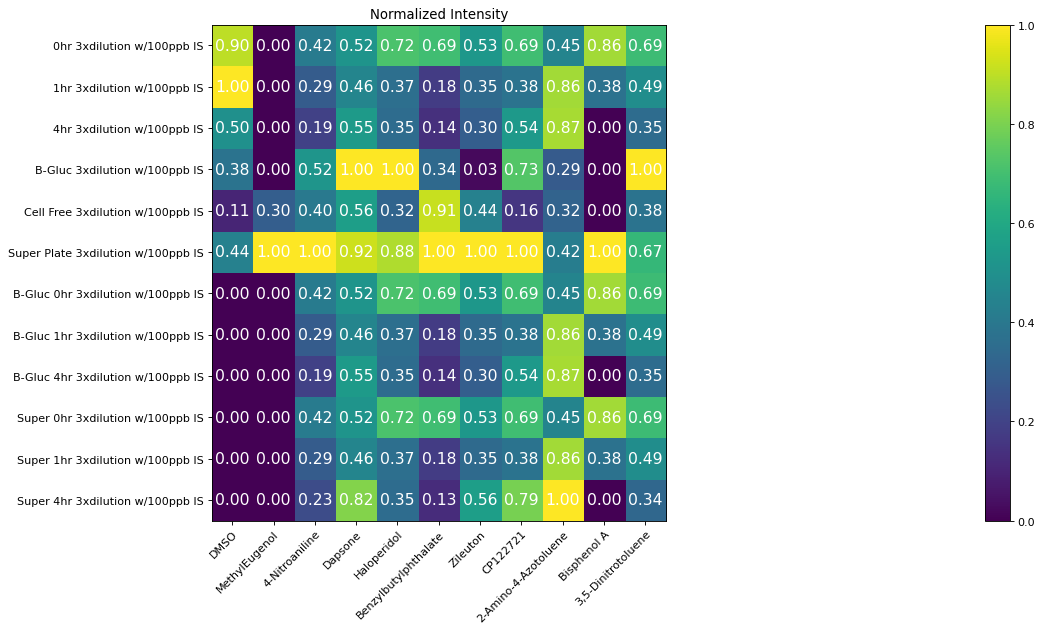

In [263]:
fig, ax = plt.subplots(figsize=(80, 8), dpi= 80, facecolor='w', edgecolor='k')
im = ax.imshow(parent_DF)


# We want to show all ticks...
ax.set_xticks(np.arange(len(parent_molecules)))
ax.set_yticks(np.arange(len(samples)))
# ... and label them with the respective list entries
ax.set_xticklabels(parent_molecules)
ax.set_yticklabels(samples)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(samples)):
    for j in range(len(parent_molecules)):
        text = ax.text(j, i, '%.2f'%parent_DF.loc[samples[i],j],
                       ha="center", va="center", color="w", fontsize=14)

plt.colorbar(im)
ax.set_title("Normalized Intensity")
fig.tight_layout()
plt.show()

In [236]:
[i,j]

[0, 0]

In [46]:
chemDict[chemDictKeys[2]]['-']['Summary'].filter(regex = r'(Resp. Mean|Sample)')['4methyl2pentanone_C6H10O3_M-H RT Resp. Mean']

0    32997.7
1      31088
2      34206
3        NaN
4        NaN
5        NaN
Name: 4methyl2pentanone_C6H10O3_M-H RT Resp. Mean, dtype: object

In [ ]:

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        axs[x,0].text(rect.get_x() + rect.get_width()*offset[xpos], 0.9*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
        


fig, axs = plt.subplots(metab_Comp.shape[0],2, gridspec_kw = {'hspace':0,'wspace':0},figsize = (14, 75))
colors = ['r','g','b','m','c']
image_List = [Chem.Draw.MolToImage(Chem.MolFromSmiles(x)) for x in Parent_DF['SMILES']]
for x in range(metab_Comp.shape[0]):
    rect1 =  axs[x,0].bar(matchList, metab_Comp.loc[x, matchList], color = colors)
    autolabel(rect1)
    axs[x,1].imshow(image_List[x])
    axs[x,1].axis('off')
    axs[x,1].annotate(metab_Comp.loc[x, 'DTXSID'], xy = (0.0,0.3))
